# Segmentation of skin lesions using U-Net

### Andrés Anobile Pérez
### Tamara Vaudroz

This project uses a UNet neural network to perform the segmantation of skin lesions images. The images were taken from [HAM10000 dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T).

The steps to segment the images are detailed through this notebook and they are part of the final project of the CAS-Advance Machine Learning

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import os
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

Paths for the training and segmented images. Due to the large size of these images to be used in a CNN, they will resized to a squre size of 280 pixels.

In [16]:
train_path = "/Users/aperez/Documents/Advanced Machine Learning/Project/Skin lesions/DATA/Training"
target_path = "/Users/aperez/Documents/Advanced Machine Learning/Project/Skin lesions/DATA/segmented"
test_path = "/Users/aperez/Documents/Advanced Machine Learning/Project/Skin lesions/DATA/Test"
model = "/Users/aperez/Documents/Advanced Machine Learning/Project/Skin lesions/Code/Models/models_hard_dropout_0_input"

img_width = 600     
img_height = 450    

resized_width = 256
resized_height = 192

In [3]:
def display_image(img):
    
    if len(img.shape) == 3:
        img = np.squeeze(img)
    v_max = 1
    if img.max() > 1:
        v_max = 255
    plt.imshow(img, cmap='gray', vmin=0, vmax=v_max)    

## Image processing

The input RGB image is pre-processed before being being inputed in the UNet. The pre-processing is done in both training and prediction scenarios. For that, a sequence of the morphological operator "closing" is applied in order to smooth out the skin hair. The morphological operators are applied using one dimensional kernels in the following sequence: main diagonal, secondary diagonal, vertical and horizontal. 

The image is then down sized from 600x450 to 256x192. We noticed that with the original size, the training time and amount of used memory, would be prohibitive for the hardware available. 

The function resizeToSquare, resizes an rectangular image to a square size keeping the image ration unchanged. The gaps are filled with zeroes. This function however was not used since since it was perfectaly possible to train the UNet with non-square images

In [4]:
def close(img, kernel):
    return cv.erode(cv.dilate(img, kernel), kernel)


def smoothHair(img):
    
    identity = np.identity(7, dtype=np.uint8)
    secondary = np.fliplr(identity)

    vertical = np.zeros((7,7), dtype=np.uint8)
    vertical[:, 3] = 1

    horizontal = np.zeros((7,7), dtype=np.uint8)
    horizontal[3, :] = 1

    return close(close(close(close(img, identity),secondary), vertical), horizontal)
     

def ceildiv(a,b):
    return -(-a//b)

#TODO: find a better name for this function
def calcCropIndices(originalDim, croppedDim):
    d = originalDim - croppedDim
    start = ceildiv(d,2)
    end = d//2

    return start, end

def cropFill(img, height, width):

    imgWidth = img.shape[1]
    imgHeight = img.shape[0]

    #crop
    if(height < imgHeight):
        start,end = calcCropIndices(imgHeight, height)
        img = img[start:imgHeight-end,...]
    if(width < imgWidth):
        start,end = calcCropIndices(imgWidth, width)
        img = img[:,start:imgWidth-end,...]

    #expand
    if(height > imgHeight):
        top,botton = calcCropIndices(height, imgHeight)
        img = cv.copyMakeBorder(img, top, botton, 0, 0, cv.BORDER_CONSTANT)
    if(width > imgWidth):
        left,right = calcCropIndices(width, imgWidth)
        img = cv.copyMakeBorder(img, 0, 0, left, right, cv.BORDER_CONSTANT)

    return img

def resizeToSquare(img, src_size, dst_size):    
        
    max_dim=max(src_size)
    img = cropFill(img, max_dim, max_dim)
    return cv.resize(img, (dst_size, dst_size), interpolation = cv.INTER_AREA)
    

def resize(img):
    return cv.resize(img, (resized_width, resized_height))

## Dataset loading functions

The functions below will open the training set and target set into tow arrays. The input images are pre-processed before being appended to the training list. Since the target images (labels) are binary (input image manually segmented) they only have to be resized with no further pre-processing. 

In [5]:
def getInputFileNames(path):
    files = sorted(os.listdir(path))
    return [os.path.join(path, f) for f in files]

def getTargetFileName(sourceFile):
    return os.path.splitext(os.path.basename(sourceFile))[0]+"_segmentation.png"
    
def getTargetFileNames(path, inputFiles):
    return [os.path.join(path, getTargetFileName(f)) for f in inputFiles]

def processInputImage(img):
        return resize(smoothHair(img))/255

def processLabelImage(img):
    return resize(img)/255


def openSegmentedImage(lesionImgFileName):
    fileName = os.path.join(target_path, getTargetFileName(lesionImgFileName))
    return processLabelImage(cv.imread(fileName, cv.IMREAD_GRAYSCALE))


def loadTraining(numImages):

    trFiles = getInputFileNames(train_path)[:numImages]
    lblFiles = getTargetFileNames(target_path, trFiles)

    x_train = np.empty((numImages, resized_height,resized_width, 1), dtype=np.float)
    y_train = np.empty((numImages, resized_height,resized_width, 1), dtype=np.float)

    for i, fileNames in enumerate(zip(trFiles, lblFiles)):
        img = processInputImage(cv.imread(fileNames[0], cv.IMREAD_GRAYSCALE))
        x_train[i, ...] = np.reshape(img, (resized_height,resized_width,1))

        mask = processLabelImage(cv.imread(fileNames[1], cv.IMREAD_GRAYSCALE))
        y_train[i, ...] = np.reshape(mask, (resized_height,resized_width,1))


    return x_train, y_train

## Defines the UNet model

The UNet has 4 encoding layers, a middle layer and 4 decoding layers. The number of kernels starts with 64 and is cremented by 64*2^layer_num for each layer_num from 0 to 3 until the middle layer where the number of kernels is 64*2^4. 

Except for the input and outpyt layers, a dropout of 40% was used. The dropouts were removed from the input and output after training a few different configurations and noting that the training error and test error were still relatively high. 

In [6]:
class UNet:

    def __init__(self, input_layer):
        self.input_layer = input_layer
        self.paddingType = "same"

    def build_model(self, start_neurons):
        
        conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding=self.paddingType)(self.input_layer)
        conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding=self.paddingType)(conv1)
        pool1 = layers.MaxPooling2D((2, 2))(conv1)
        #pool1 = layers.Dropout(0.2)(pool1)

        conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding=self.paddingType)(pool1)
        conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding=self.paddingType)(conv2)
        pool2 = layers.MaxPooling2D((2, 2))(conv2)
        pool2 = layers.Dropout(0.4)(pool2)

        conv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding=self.paddingType)(pool2)
        conv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding=self.paddingType)(conv3)
        pool3 = layers.MaxPooling2D((2, 2))(conv3)
        pool3 = layers.Dropout(0.4)(pool3)

        conv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding=self.paddingType)(pool3)
        conv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding=self.paddingType)(conv4)
        pool4 = layers.MaxPooling2D((2, 2))(conv4)
        pool4 = layers.Dropout(0.4)(pool4)

        # Middle
        convm = layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding=self.paddingType)(pool4)
        convm = layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding=self.paddingType)(convm)

        deconv4 = layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding=self.paddingType)(convm)
        uconv4 = layers.concatenate([deconv4, conv4])
        uconv4 = layers.Dropout(0.4)(uconv4)
        uconv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding=self.paddingType)(uconv4)
        uconv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding=self.paddingType)(uconv4)
        

        deconv3 = layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding=self.paddingType)(uconv4)
        uconv3 = layers.concatenate([deconv3, conv3])
        uconv3 = layers.Dropout(0.4)(uconv3)
        uconv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding=self.paddingType)(uconv3)
        uconv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding=self.paddingType)(uconv3)

        deconv2 = layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding=self.paddingType)(uconv3)
        uconv2 = layers.concatenate([deconv2, conv2])
        uconv2 = layers.Dropout(0.4)(uconv2)
        uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding=self.paddingType)(uconv2)
        uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding=self.paddingType)(uconv2)

        deconv1 = layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding=self.paddingType)(uconv2)
        uconv1 = layers.concatenate([deconv1, conv1])
        #uconv1 = layers.Dropout(0.2)(uconv1)
        uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding=self.paddingType)(uconv1)
        uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding=self.paddingType)(uconv1)

        output_layer = layers.Conv2D(1, (1,1), padding=self.paddingType, activation="sigmoid")(uconv1)

        return output_layer

## Training

Even though in the code below it appears that 3000 images were used for the training, in fact only 1500 where used. From these, 100 images were manually selected according to their visual dificulty to clearly define the border of the skin lesion. 

In [7]:
total_images = 3000
train_n = 2400

def buildModel(input_shape):
    input_layer = layers.Input(input_shape)
    model = UNet(input_layer)
    output_layer = model.build_model(64)

    unet = Model(input_layer, output_layer)
    unet.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return unet

In [8]:
def train(epochs, batch_size):
    train_x, train_y = loadTraining(total_images)
    unet = buildModel((resized_height,resized_width, 1))
    history = unet.fit(train_x[:train_n], train_y[:train_n], epochs=epochs, batch_size=batch_size, validation_data=(train_x[train_n+1:], train_y[train_n+1:]))   
    unet.save("/Users/aperez/Documents/Advanced Machine Learning/Project/Skin lesions/Code/Models/model_10_11_2020")
    
    return history, unet


In [9]:
def predict(model, image):
    testImg= processInputImage(cv.cvtColor(image, cv.COLOR_BGR2GRAY))
    test_shape = (1,resized_height,resized_width,1)
    test = np.reshape(testImg, test_shape)
    
    return np.squeeze((model.predict(test)))*255

In [257]:
#hist, unet = train(4, 300)

Epoch 1/4
8/8 [==============================] - 6614s 795s/step - loss: 0.6080 - accuracy: 0.7293 - val_loss: 0.5368 - val_accuracy: 0.7301
Epoch 2/4
8/8 [==============================] - 5587s 698s/step - loss: 0.5339 - accuracy: 0.7310 - val_loss: 0.5282 - val_accuracy: 0.7301
Epoch 3/4
8/8 [==============================] - 5777s 726s/step - loss: 0.5337 - accuracy: 0.7333 - val_loss: 0.5129 - val_accuracy: 0.7297
Epoch 4/4
8/8 [==============================] - 5893s 747s/step - loss: 0.4920 - accuracy: 0.7438 - val_loss: 0.5538 - val_accuracy: 0.7403
INFO:tensorflow:Assets written to: /Users/aperez/Documents/Advanced Machine Learning/Project/Skin lesions/Code/Models/model_10_11_2020/assets


## UNet model summary

In [17]:
unet = tf.keras.models.load_model(model)

In [52]:
unet.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 192, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 192, 256, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 192, 256, 64) 36928       conv2d_57[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 96, 128, 64)  0           conv2d_58[0][0]                  
_______________________________________________________________________________________

## Test Code

In the test below, a image from the test set is loaded and goes through the following workflow:


Image filtering (hair smoothing)

Resize to 256 x 192

Converted to grayscale

Input into UNet

Normalized output of UNet rescaled from 0..1 to 0..255

Otsu automatic threshould is used to make a binary mask

The mask is used to isoloate only the lesion part of the image


In [18]:
testFiles = getInputFileNames(test_path)

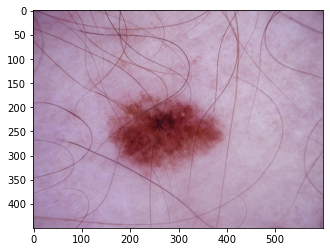

In [19]:
idx = 1000
#idx=18 #hard one
src_image = cv.imread(testFiles[idx])
plt.imshow(cv.cvtColor(src_image, cv.COLOR_BGR2RGB))
plt.show()

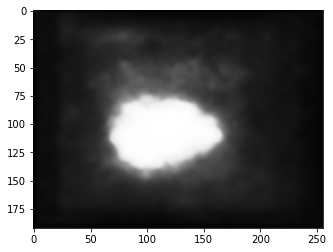

In [20]:
predicted = predict(unet, src_image)
display_image(predicted)

In [21]:
img = predicted.astype(np.uint8)
ret2,mask_ = cv.threshold(img,0,1,cv.THRESH_BINARY+cv.THRESH_OTSU)
print(ret2)


130.0


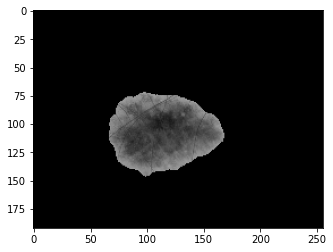

In [22]:

display_image(resize(cv.cvtColor(src_image, cv.COLOR_BGR2GRAY)) * mask_)


### Comparing the image segmented by the UNet with the manually segmented ones

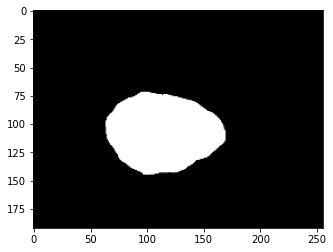

In [23]:
Y = openSegmentedImage(testFiles[idx])
display_image(Y)

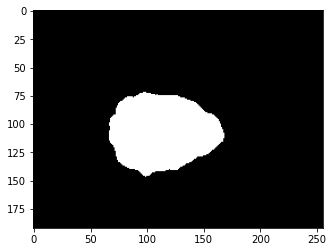

In [24]:
display_image(mask_)

The Jaccard index is 93.4417628541448%


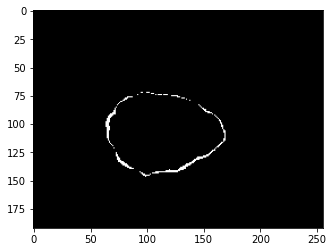

In [25]:

a = np.array(mask_, np.uint8)
b = np.array(Y, np.uint8)
display_image(cv.bitwise_xor(a,b))

jaccard = np.sum(np.logical_and(a,b))/np.sum(np.logical_or(a,b))

print(f'The Jaccard index is {jaccard*100}%')


## Lokking into the UNet kernels

Below we select a few kernels and manually apply the convolution onto the input images. 
For a layer with N kernels, we compute the N convulutions (N output images), multiply the pixels by the factor 1/N
and sum these N images into one.


In [26]:
def layerConv(image, kernels):
    n = kernels.shape[-1]
    ratio = 1/n
    images = list()
    for i in range(0, n):
        kernel = np.array(kernels[...,i])
        images.append(cv.filter2D(image, -1, kernel)*255)
    
    blend = images[0]*ratio
    for i in range(1, n):
        blend = blend + images[i]*ratio
        
    min = blend.min()*(-1)
    return blend+min*1.2

#### Input image

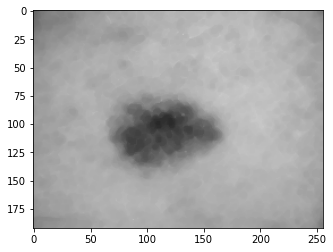

In [27]:
src = processInputImage(cv.cvtColor(src_image, cv.COLOR_BGR2GRAY))
display_image(src)

#### Select a kernel

In [30]:
layer = 36
depth = 46

print(unet.layers[layer].kernel.shape)
kernels = unet.layers[layer].kernel[...,depth,:]
print(kernels.shape)

(3, 3, 64, 64)
(3, 3, 64)


#### Apply the convolutions

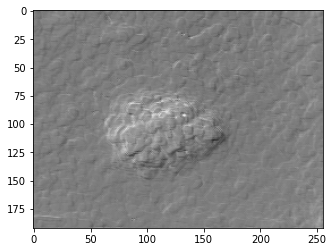

In [31]:
convImg = layerConv(src, kernels)
plt.imshow(convImg, cmap='gray', vmin=0, vmax=convImg.max()) 
plt.show()

### A few interesting kernels

In [ ]:

layer = 36
depth = 5
layer = 36
depth = 18
layer = 36
depth = 22
layer = 36
depth = 34
layer = 36
depth = 46
